# Before we begin...

For this demonstration, we are evaluating the candidate Bill Gates. We have been given the Twitter account handle and the NGO's area of interest(s).

We will visualize the features of the candidate's Twitter profile and assess all data that can be immediately gained from the metadata returned by the Twitter API.

Using NLP, we will perform topic analysis on the candidate's tweet corpus and view the relevance of the candidate's tweets with our model which is trained on the NASW twitter account.

Elasticsearch is a search engine which will query the NGO's area of interest(s) on our model and find matches to topics in our trained model. We will then check the relevance of that topic with that of the candidate and its priority in terms of what the candidate has been talking about.

We will evaluate all the features of the candidate on the trained model and predict the labels for each tweet. The labels can then be plotted to visualize their variance.

# Booting up our application...

### Importing dependencies

In [1]:
print("\nImporting dependencies...")

import tweepy
import pickle
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from credentials import *
from elasticsearch import Elasticsearch
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import gensim
import pyLDAvis.gensim

print("\nAll dependencies imported")


Importing dependencies...


c:\users\p k das\appdata\local\programs\python\python36-32\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")



All dependencies imported


### Importing necessary modules

In [2]:
print("\nLoading tweets...")
save = "gates_df.pickle"
with open(save, 'rb') as f:
    data = pickle.load(f)

save = "followers.pickle"
with open(save, 'rb') as f:
    followers = pickle.load(f)

save = "friends.pickle"
with open(save, 'rb') as f:
    friends = pickle.load(f)
print("\nDone")

print("\nLoading hashtags...")
save = "hashtags.pickle"
with open(save, 'rb') as f:
    hashtags = pickle.load(f)
print("\nDone")
    
print("\nLoading trained LDA and LSI topic models...")
save = "ldamodel.pickle"
with open(save, 'rb') as f:
    ldamodel = pickle.load(f)
        
save = "lsimodel.pickle"
with open(save, 'rb') as f:
    lsimodel = pickle.load(f)
print("\nDone")
        
print("\nLoading candidate's topic distribution...")    
save = "gates_topic_dist"
with open(save, 'rb') as f:
    topic_dist = pickle.load(f)
print("\nDone")

print("\nLoading ranking module...")
save = "clf_lin_fit.pickle"
with open(save, 'rb') as f:
    clf_lin = pickle.load(f)
print("\nDone")
        
print("\nLoading scaler to scale features for ranking...")
save = "scaler.pickle"
with open(save, 'rb') as f:
    scaler = pickle.load(f)
print("\nDone")

print("\nLoading another candidate's dataframe to compare...")
save = "obama_df_with_topic.pickle"
with open(save, 'rb') as f:
    obama_df = pickle.load(f)
print("\nDone")


Loading tweets...

Done

Loading hashtags...

Done

Loading trained LDA and LSI topic models...

Done

Loading candidate's topic distribution...

Done

Loading ranking module...

Done

Loading scaler to scale features for ranking...

Done

Loading another candidate's dataframe to compare...

Done


### A bird's eye view

In [3]:
print("\nCreating a brief overview of the candidate...")

print("\nCandidate has",followers,"followers and",friends,"friends\n")

print("Computing sentiments of the candidate's tweets...")
print("\nDone")
print("\nCreating and loading a dataframe of the candidate's tweets: ")
data.head()


Creating a brief overview of the candidate...

Candidate has 42718161 followers and 20 friends

Computing sentiments of the candidate's tweets...

Done

Creating and loading a dataframe of the candidate's tweets: 


,tweet,len,date,source,likes,retweets,isRetweet,urls,hashtags,SA
0,I’m optimistic we can stop climate change and ...,182,2017-12-22 15:55:14,Media Studio,2078,585,0,1,0,1
1,Melinda and I have been working for some time ...,280,2017-12-20 17:36:45,Twitter Web Client,6514,1165,0,1,0,1
2,I appreciate how thoughtful my friend @RayDali...,210,2017-12-19 21:43:48,Twitter Web Client,2690,399,0,1,0,1
3,9/ These tweets made me feel better about 2017...,167,2017-12-19 14:51:27,Twitter Web Client,7873,915,0,0,0,1
4,8/ Here’s my own extreme submission to the cha...,93,2017-12-19 14:51:27,Twitter Web Client,6280,632,0,0,1,1


## General Statistics

In [4]:
# sources

sources = []
for source in data['source']:
    if source not in sources:
        sources.append(source)
        
# sources = [re.sub(r"</?.*?>","",source) for source in sources]
        
# We print sources list:
print("Sources used by the candidate for tweeting: \n")
for source in sources:
    print("* {}".format(source))

Sources used by the candidate for tweeting: 

* Media Studio
* Twitter Web Client
* Twitter for Windows
* Twitter Lite
* Sprinklr
* Twitter Ads
* Twitter for Windows Phone
* Hootsuite


In [5]:
# Elementary statistics

mean = np.mean(data['len'])
print("\nAverage length of tweets: {}".format(mean))

fav_max = np.max(data['likes'])
rt_max  = np.max(data['retweets'])

fav = data[data.likes == fav_max].index[0]
rt  = data[data.retweets == rt_max].index[0]

# Max FAVs:
print("\nThe tweet with the highest likes is: \n{}".format(data['tweet'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} is the date.".format(data['date'][fav]))
print("The retweets: {}".format(data['retweets'][fav]))

# Max RTs:
print("\nThe tweet with the highest retweets is: \n{}".format(data['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} is the date.".format(data['date'][rt]))
print("The likes: {}".format(data['likes'][rt]))


Average length of tweets: 131.462

The tweet with the highest likes is: 
Happy Father’s Day, Dad! Thank you for making me into the man I am today. https://t.co/aOgOPOmuAK
Number of likes: 37076
2017-06-18 12:32:01 is the date.
The retweets: 5555

The tweet with the highest retweets is: 
#RedNoseDay is a week away! Tweet or RT using #RedNose4Kids and our foundation will donate $10 to end child poverty. https://t.co/yceQAPY2Td
Number of retweets: 24965
2016-05-19 16:26:18 is the date.
The likes: 24307


## General Visualizations

### Time Series


Variation of length of tweets over time: 


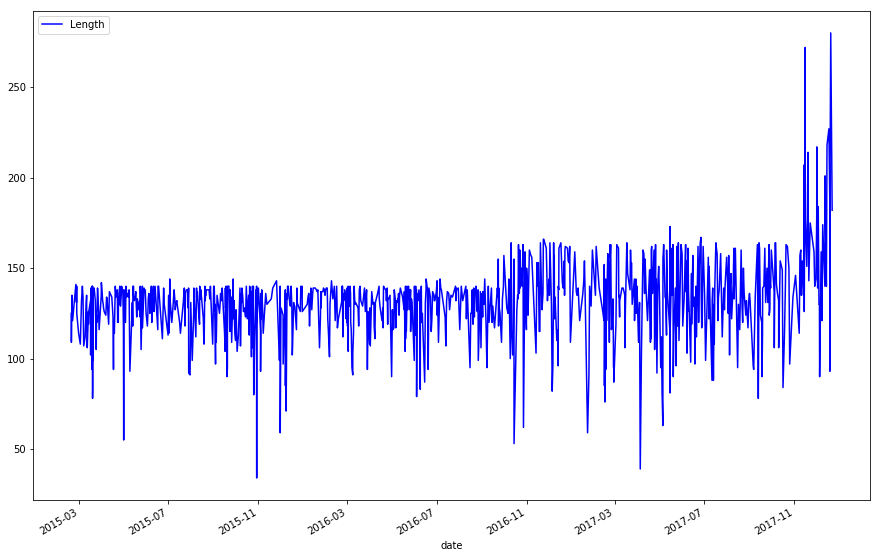

In [6]:
tlen = pd.Series(data=data['len'].values, index=data['date'])

print("\nVariation of length of tweets over time: ")
tlen.plot(figsize=(15,10), color='b', label='Length', legend=True);


Variation of likes over time: 


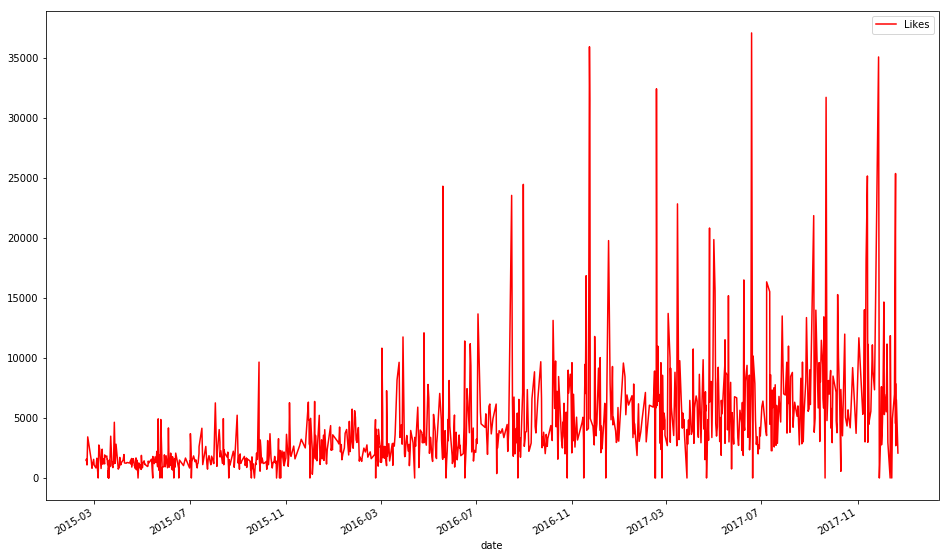

In [7]:
tfav = pd.Series(data=data['likes'].values, index=data['date'])

print("\nVariation of likes over time: ")
tfav.plot(figsize=(16,10), color='r', label='Likes', legend=True);


Variation of retweets over time: 


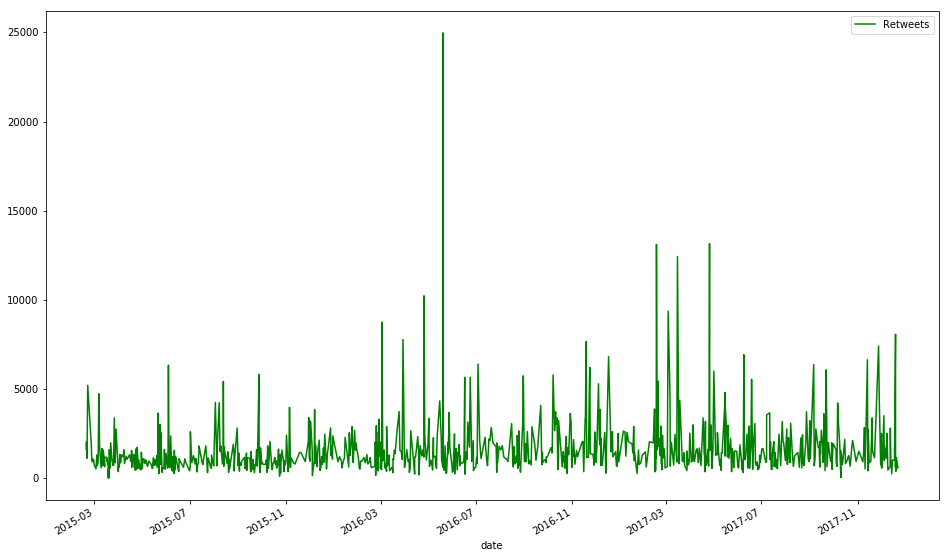

In [8]:
tret = pd.Series(data=data['retweets'].values, index=data['date'])

print("\nVariation of retweets over time: ")
tret.plot(figsize=(16,10), color='g', label='Retweets', legend=True);

### Visualizing sentiments

Pie chart of the sentiment distribution of the candidate's tweets: 


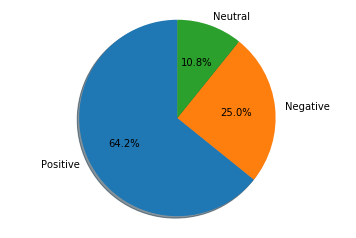

In [9]:
# Acquiring percentages 

pos_tweets = [ tweet for index, tweet in enumerate(data['tweet']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['tweet']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['tweet']) if data['SA'][index] < 0]

per_pos = len(pos_tweets)*100/len(data['tweet'])
per_neu = len(neu_tweets)*100/len(data['tweet'])
per_neg = len(neg_tweets)*100/len(data['tweet'])

# Making a pie chart

labels = 'Positive', 'Negative', 'Neutral'
sizes = []
sizes.extend((per_pos, per_neu, per_neg))

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

print("Pie chart of the sentiment distribution of the candidate's tweets: ")
plt.show()

In [10]:
# Function to generate word cloud

print("\nCompiling function to generate word cloud...")
def createWordCloud(all_hashtags_list):
    wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(all_hashtags_list))
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
print("\nDone")


Compiling function to generate word cloud...

Done


### Visualizing hashtags


Generating word cloud...


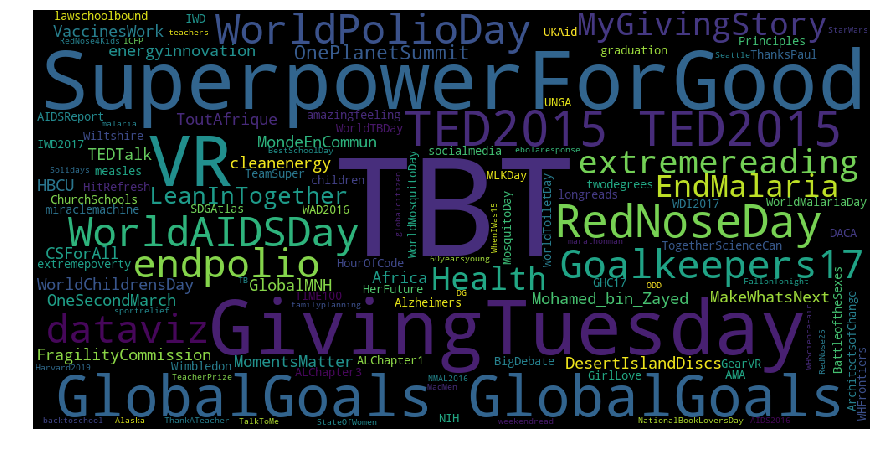

In [11]:
print("\nGenerating word cloud...")
createWordCloud(hashtags)

# Topic Modeling

In [12]:
# connect to our cluster
print("Connecting to the elasticsearch cluster...")
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
print("Done")

Connecting to the elasticsearch cluster...
Done


In [13]:
# Searching for keywords in the documents

print("\nPassing queries on topics...")

res = es.search(doc_type="lsi", body={"query": {"match": {"content": "mental health"}}})
print("%d relevant document(s) found: " % res['hits']['total'])
print("Printing topic...")
for doc in res['hits']['hits']:
    print("\n%s) %s" % (doc['_id'], doc['_source']['content']))
    id = doc['_id']
    break
    
id = int(id) - 1
print("\nThe ID of the relevant topic is:",id)


Passing queries on topics...
5 relevant document(s) found: 
Printing topic...

3) (2, '-0.639*"amp" + -0.444*"health" + -0.304*"care" + 0.232*"social" + 0.230*"nasw" + 0.155*"worker" + -0.105*"alonenotalone" + -0.094*"older" + -0.092*"swinhealth" + -0.082*"mental"')

The ID of the relevant topic is: 2


In [14]:
print("\nLoading topic relevance of the candidate as a feature...")
data['topic_relevance'] = topic_dist[id]
print("\nRemoving outlier values...")
data = data.fillna(0)
print("\nAugmented dataframe of the candidate: ")
data.head()


Loading topic relevance of the candidate as a feature...

Removing outlier values...

Augmented dataframe of the candidate: 


,tweet,len,date,source,likes,retweets,isRetweet,urls,hashtags,SA,topic_relevance
0,I’m optimistic we can stop climate change and ...,182,2017-12-22 15:55:14,Media Studio,2078,585,0,1,0,1,-0.048981
1,Melinda and I have been working for some time ...,280,2017-12-20 17:36:45,Twitter Web Client,6514,1165,0,1,0,1,-0.067248
2,I appreciate how thoughtful my friend @RayDali...,210,2017-12-19 21:43:48,Twitter Web Client,2690,399,0,1,0,1,-0.005413
3,9/ These tweets made me feel better about 2017...,167,2017-12-19 14:51:27,Twitter Web Client,7873,915,0,0,0,1,0.002585
4,8/ Here’s my own extreme submission to the cha...,93,2017-12-19 14:51:27,Twitter Web Client,6280,632,0,0,1,1,-0.002037


In [15]:
topic_wise = topic_dist.mean(axis=0)

what = topic_wise.idxmax()
print("\nThe candidate's tweets have the maximum relevance to topic ",what)

print("\nThe topic relevant to the NGO's area of interest(s) is ",id)

if id == what:
    print("\nThe candidate's highest relevant topic matches the NGO's area of interest(s)")
else:
    print("\nThe candidate's highest relevant topic DOES NOT matches the NGO's area of interest(s)")
    
print("\nThe topic relevance of the NGO's area of interest(s) pertaining to the candidate is: ",topic_wise[id])


The candidate's tweets have the maximum relevance to topic  0

The topic relevant to the NGO's area of interest(s) is  2

The candidate's highest relevant topic DOES NOT matches the NGO's area of interest(s)

The topic relevance of the NGO's area of interest(s) pertaining to the candidate is:  -0.0514655475446


# Ranking the candidate's features

In [16]:
print("\nScaling the likes and retweets of the candidate...")

elimcolumns=["likes","retweets"]
X_train_np = data[elimcolumns].values
X_train_np = scaler.transform(X_train_np)
data[elimcolumns] = X_train_np

print("\nDone. The scaled dataframe is: ")
data.head()


Scaling the likes and retweets of the candidate...

Done. The scaled dataframe is: 


c:\users\p k das\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,tweet,len,date,source,likes,retweets,isRetweet,urls,hashtags,SA,topic_relevance
0,I’m optimistic we can stop climate change and ...,182,2017-12-22 15:55:14,Media Studio,21.650883,13.983485,0,1,0,1,-0.048981
1,Melinda and I have been working for some time ...,280,2017-12-20 17:36:45,Twitter Web Client,68.247976,28.072982,0,1,0,1,-0.067248
2,I appreciate how thoughtful my friend @RayDali...,210,2017-12-19 21:43:48,Twitter Web Client,28.079517,9.465130,0,1,0,1,-0.005413
3,9/ These tweets made me feel better about 2017...,167,2017-12-19 14:51:27,Twitter Web Client,82.523326,21.999923,0,0,0,1,0.002585
4,8/ Here’s my own extreme submission to the cha...,93,2017-12-19 14:51:27,Twitter Web Client,65.789969,15.125221,0,0,1,1,-0.002037


In [17]:
print("\nExtracting the candidate's features for ranking...")
X = data.iloc[:,4:].values
print("\nPassing the features through the trained model and acquiring predicted labels...")
linReg = clf_lin.predict(X)

linReg.mean()


Extracting the candidate's features for ranking...

Passing the features through the trained model and acquiring predicted labels...


1.1147047745004592

### Comparing with the second candidate

In [18]:
print("\nScaling the likes and retweets of the second candidate...")

obama_elimcolumns=["likes","retweets"]
obama_X_train_np = obama_df[obama_elimcolumns].values
obama_X_train_np = scaler.transform(obama_X_train_np)
obama_df[obama_elimcolumns] = obama_X_train_np

print("\nDone. The scaled dataframe is: ")
obama_df.head()


Scaling the likes and retweets of the second candidate...

Done. The scaled dataframe is: 


c:\users\p k das\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,tweet,len,date,source,likes,retweets,isRetweet,urls,hashtags,SA,topic_relevance
0,RT Alliance I am my Brother s Keeper Watc...,144,2017-12-27 21:02:52,Twitter for iPhone,-0.177061,121.695259,0,0,0,1,-0.695313
1,On behalf of the Obama family Merry Christmas...,118,2017-12-25 16:05:05,Twitter for iPhone,15022.206809,6174.761693,0,0,0,1,0.001073
2,There s no better time than the holiday season...,191,2017-12-14 22:39:13,Twitter for iPhone,4311.934312,1463.671240,0,0,0,1,-0.706608
3,Happy Hanukkah everybody from the Obama fami...,72,2017-12-13 00:17:20,Twitter for iPhone,7265.996729,2095.730922,0,0,0,1,-0.019031
4,Just got off a call to thank folks who are wor...,256,2017-12-11 20:16:29,Twitter for iPhone,2370.297733,2141.424618,0,2,0,1,-0.619519


In [19]:
print("\nRemoving NaN values...")
obama_df = obama_df.fillna(0)

print("\nExtracting the second candidate's features for ranking...")
obama_X = obama_df.iloc[:,4:].values
print("\nPassing the features through the trained model and acquiring predicted labels...")
obama_linReg = clf_lin.predict(obama_X)
print("\nDone")

obama_linReg.mean()


Removing NaN values...

Extracting the second candidate's features for ranking...

Passing the features through the trained model and acquiring predicted labels...

Done


8.3594311040370979


Plotting variance of predicted values...


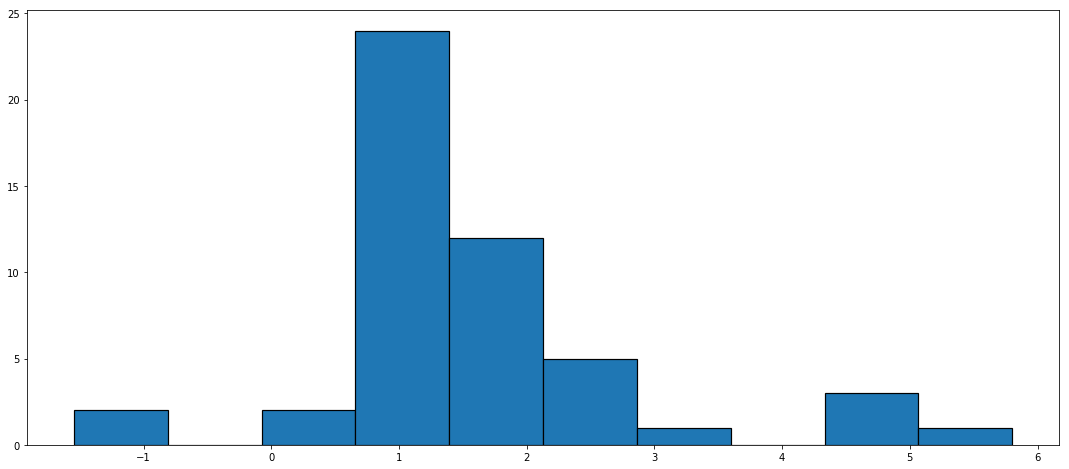

In [20]:
print("\nPlotting variance of predicted values...")

plt.hist(linReg[:50], edgecolor='black', linewidth='1.2')
fig = plt.gcf()
fig.set_size_inches(18.5, 8)

plt.show()


Candidate 1: 


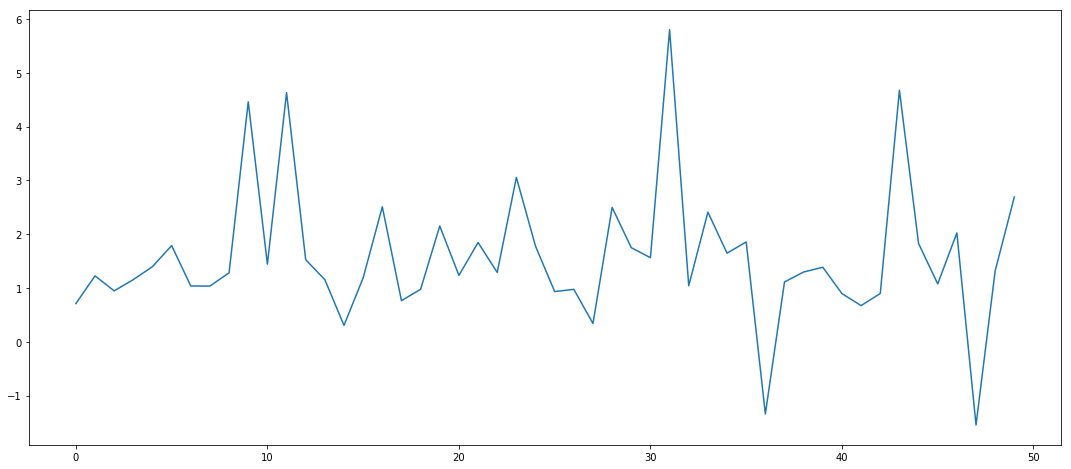

In [21]:
print("\nCandidate 1: ")

plt.plot(linReg[:50])
fig = plt.gcf()
fig.set_size_inches(18.5, 8)

plt.show()


Candidate 2: 


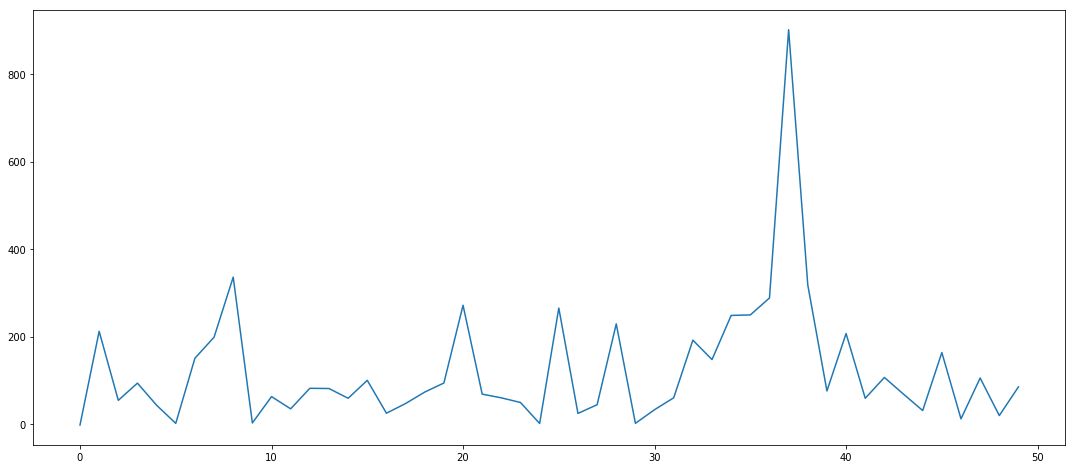

In [22]:
print("\nCandidate 2: ")

plt.plot(obama_linReg[:50])
fig = plt.gcf()
fig.set_size_inches(18.5, 8)

plt.show()